# 02 — LSTM word2vec
- **Задача**. Бинарная классификация твитов о кризисах: Related & informative vs Not informative. Модель обучается на подготовленном train и проверяется на отдельном test (валидация — из val_split внутри трейна).

- **Модель**. Классический LSTM-классификатор: Embedding(num_words, 50) → SpatialDropout1D → LSTM(256) → Dense(256, ReLU) → Dense(1) (логит). Функция потерь — бинарная кроссэнтропия; оптимизатор — Adam.

- **Предобработка текста**. Токенизация и индексация с помощью keras_preprocessing.Tokenizer, паддинг до max_length с pad_sequences. Ограничение словаря vocabulary_size и пост-паддинг (совместимо с PyTorch-даталоадером).

- **Обучение и логирование**. Батч-тренинг с валидационным сплитом (val_split≈0.15), эпохи/батч/дропаут/скорость обучения — из сетки гиперпараметров (ParameterSampler + loguniform для LR). Логирование в MLflow: параметры эксперимента, кривые train/val accuracy & loss, итоговые метрики и сохранённая модель.

- **Оценка качества**. Считаются и печатаются accuracy, precision, recall, f1-score и ROC-AUC; выводится матрица ошибок/классификационный отчёт для теста.

- **Стэк**: Python, PyTorch (модель/тренинг), numpy/pandas/matplotlib, scikit-learn (метрики и семплер гиперпараметров), keras_preprocessing (токенизация/паддинг), MLflow (эксперименты).

In [1]:
!pip install keras-preprocessing mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.1/329.1 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.4/718.4 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96

In [14]:
from google.colab import drive
drive.mount('/content/drive')

import os, re, json, random, six
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import torchvision

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc,
    roc_auc_score, ConfusionMatrixDisplay
)

from scipy.stats import loguniform
from sklearn.model_selection import ParameterSampler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import mlflow, mlflow.pytorch, inspect
from mlflow.models import infer_signature

from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

device = "cuda"

def set_seeds(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seeds(42)

def setup_mlflow(experiment_name: str, base_dir: str = None):
    base_dir = base_dir or os.getcwd()
    tracking_dir = os.path.join(base_dir, "mlruns")
    os.makedirs(tracking_dir, exist_ok=True)
    mlflow.set_tracking_uri(pathlib.Path(tracking_dir).absolute().as_uri())
    mlflow.set_experiment(experiment_name)
setup_mlflow("LSTM")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def evaluate(y_test, y_pred, mlflow_client=None):
    """
    y_pred: probability scores in [0,1]
    """
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    mauc = auc(fpr, tpr)

    y_bin = (y_pred > 0.5).astype(int)
    labels = ['Not informative', 'Related and informative']
    confusion = confusion_matrix(y_test, y_bin)
    df_cm = pd.DataFrame(confusion, index=[i for i in labels], columns=[i for i in labels])

    accuracy  = accuracy_score(y_test, y_bin)
    precision = precision_score(y_test, y_bin)
    recall    = recall_score(y_test, y_bin)
    f1score   = f1_score(y_test, y_bin)

    report = classification_report(y_test, y_bin, target_names=labels)
    print(report)

    if mlflow_client is not None:
        mlflow.log_metric("accuracy", float(accuracy))
        mlflow.log_metric("precision", float(precision))
        mlflow.log_metric("recall", float(recall))
        mlflow.log_metric("f1score", float(f1score))
        mlflow.log_metric("mAUC", float(mauc))
    return accuracy, precision, recall, f1score, mauc


def mlflow_log_parameters(cat, parameter):
    mlflow.log_param("crisis_type", cat)
    mlflow.log_param("dropout", parameter['dropout'])
    mlflow.log_param("learning_rate", parameter['learning_rate'])
    mlflow.log_param("epochs", parameter['epochs'])
    mlflow.log_param("batch_size", parameter['batch_size'])

In [5]:
class VocabTokenizer:
    """Фитим словарь на train и применяем к любым текстам"""
    def __init__(self, vocabulary_size: int, max_length: int):
        self.vocabulary_size = vocabulary_size
        self.max_length = max_length
        self.tok = Tokenizer(num_words=vocabulary_size)

    def fit(self, texts):
        self.tok.fit_on_texts(list(texts))

    def transform(self, texts):
        seqs = self.tok.texts_to_sequences(list(texts))
        padded = pad_sequences(seqs, maxlen=self.max_length, padding='post', truncating='post')
        return padded.astype('int64')

class SpatialDropout1D(nn.Dropout1d):
    def forward(self, x):
        x = x.transpose(1, 2)
        x = super().forward(x)
        return x.transpose(1, 2)

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=50, hidden_size=256, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.spatial = SpatialDropout1D(p=0.3)
        self.lstm = nn.LSTM(embed_dim, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.relu = nn.ReLU()
        self.out = nn.Linear(256, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.spatial(x)
        out, (h, c) = self.lstm(x)
        h = h[-1]
        h = self.dropout(h)
        h = self.relu(self.fc1(h))
        logits = self.out(h).squeeze(-1)
        return logits

def create_lstm(vocabulary_size, max_length, ndropout):
    return LSTMClassifier(vocab_size=vocabulary_size, embed_dim=50, hidden_size=256, dropout=ndropout)

def train_pytorch(model, X_tr, y_tr, X_val, y_val, *, epochs, batch_size, lr=1e-3):
    model = model.to(device)
    crit = nn.BCEWithLogitsLoss()
    opt = optim.Adam(model.parameters(), lr=lr)

    tr_loader  = DataLoader(TensorDataset(torch.tensor(X_tr),  torch.tensor(y_tr)),  batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.tensor(X_val), torch.tensor(y_val)), batch_size=batch_size, shuffle=False)

    hist = {"accuracy": [], "val_accuracy": [], "loss": [], "val_loss": []}
    for _ in range(epochs):
        # --- train ---
        model.train()
        tot, cor, lsum = 0, 0, 0.0
        for xb, yb in tr_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            opt.step()
            lsum += loss.item() * xb.size(0)
            cor  += (torch.sigmoid(logits) > 0.5).float().eq(yb).sum().item()
            tot  += xb.size(0)
        hist["loss"].append(lsum/max(1,tot))
        hist["accuracy"].append(cor/max(1,tot))

        # --- val ---
        model.eval()
        vtot, vcor, vlsum = 0, 0, 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)
                logits = model(xb)
                vlsum += crit(logits, yb).item() * xb.size(0)
                vcor  += (torch.sigmoid(logits) > 0.5).float().eq(yb).sum().item()
                vtot  += xb.size(0)
        hist["val_loss"].append(vlsum/max(1,vtot))
        hist["val_accuracy"].append(vcor/max(1,vtot))

    class History:
        def __init__(self, h): self.history = h
    return model, History(hist)

def predict_proba(model, X, batch_size=512):
    model = model.to(device).eval()
    loader = DataLoader(TensorDataset(torch.tensor(X), torch.zeros(len(X))), batch_size=batch_size)
    out = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(device, non_blocking=True)
            out.append(torch.sigmoid(model(xb)).cpu().numpy())
    return np.concatenate(out, axis=0)

def training_test_mae(mlflow_client, history):
  fig, ax = plt.subplots()
  plt.plot(history.history['accuracy'], label='Training acc')
  plt.plot(history.history['val_accuracy'], label='Validation acc')
  plt.title('model accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()
  mlflow.log_figure(fig, "training_validation_accuracy.png")

  fig, ax = plt.subplots()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  mlflow.log_figure(fig, "training_validation_loss.png")

In [6]:
def evaluate_and_log(y_true, y_prob, *, mlf=None, prefix="dev"):
    fpr, tpr, _ = roc_curve(y_true, y_prob, pos_label=1)
    mauc = auc(fpr, tpr)
    y_bin = (y_prob > 0.5).astype(int)

    acc = accuracy_score(y_true, y_bin)
    pre = precision_score(y_true, y_bin)
    rec = recall_score(y_true, y_bin)
    f1  = f1_score(y_true, y_bin)

    print(classification_report(y_true, y_bin, target_names=['Not informative','Related and informative']))

    if mlf:
        mlf.log_metrics({f"{prefix}_acc":acc, f"{prefix}_pre":pre, f"{prefix}_rec":rec, f"{prefix}_f1":f1, f"{prefix}_AUC":mauc})
        # ROC
        fig = plt.figure()
        plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
        plt.title(f"{prefix.upper()} ROC AUC={mauc:.3f}")
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.grid(True)
        mlf.log_figure(fig, f"{prefix}_roc.png"); plt.close(fig)
    return acc, pre, rec, f1, mauc

def log_model_with_signature(model, max_length):
    ex = np.zeros((1, max_length), dtype=np.int64)
    sig = infer_signature(ex, np.array([0.5], dtype=np.float32))

    pip_reqs = [f"torch=={torch.__version__.split('+')[0]}"]
    pip_reqs.append(f"torchvision=={getattr(torchvision, '__version__', '0.0')}")

    params = inspect.signature(mlflow.pytorch.log_model).parameters
    mlflow.pytorch.log_model(
        pytorch_model=model,
        name="Lstm",
        input_example=ex,
        signature=sig,
        pip_requirements=pip_reqs,
    )

In [7]:
BASE_DIR = dir_path if 'dir_path' in globals() else os.getcwd()
TRACKING_DIR = os.path.join(BASE_DIR, "mlruns")
os.makedirs(TRACKING_DIR, exist_ok=True)

mlflow.set_tracking_uri(pathlib.Path(TRACKING_DIR).absolute().as_uri())
mlflow.set_experiment("LSTM_Scenario1")

2025/10/08 12:57:25 INFO mlflow.tracking.fluent: Experiment with name 'LSTM_Scenario1' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/967442287612498883', creation_time=1759928245923, experiment_id='967442287612498883', last_update_time=1759928245923, lifecycle_stage='active', name='LSTM_Scenario1', tags={}>

In [8]:
def pad_sequences(sequences, maxlen=None, dtype='int32',
                  padding='pre', truncating='pre', value=0.):
    """Pads sequences to the same length.
    This function transforms a list of
    `num_samples` sequences (lists of integers)
    into a 2D Numpy array of shape `(num_samples, maxlen)`.
    `maxlen` is either the `maxlen` argument if provided,
    or the length of the longest sequence otherwise.
    Sequences shorter than `maxlen` are padded with `value`
    at the end or at the beginning depending on the `padding` argument.
    Sequences longer than `maxlen` are truncated
    either at the beginning or at the end depending on the `truncating` argument.
    The default value for `padding`, `truncating`, and `dtype` are provided
    to maintain backward compatibility.
    Args:
        sequences: List of lists, where each element is a sequence.
        maxlen: Int, maximum length of all sequences.
        dtype: Type of the output sequences.
            To pad sequences with variable length strings, you can use `object`.
        padding: String, 'pre' or 'post':
            pad either before or after each sequence.
        truncating: String, 'pre' or 'post':
            remove values from either the beginning or the end of the sequences
            when no longer than `maxlen`.
        value: Float or String, padding value.
            (Padding with strings is supported only with dtype='object'.)
    Returns:
        Numpy array with shape `(num_samples, maxlen)`.
    Raises:
        ValueError: In case of invalid arguments.
    """
    if not hasattr(sequences, '__len__'):
        raise ValueError('`sequences` should be a list of iterables. '
                         'Found: ' + str(sequences))

    num_samples = len(sequences)
    lengths = []
    for x in sequences:
        try:
            lengths.append(len(x))
        except TypeError:
            raise ValueError('`sequences` should be a list of iterables. '
                             'Found non-iterable element: ' + str(x))

    if maxlen is None:
        maxlen = np.max(lengths)

    # Update to use np.str_ instead of np.unicode_
    is_dtype_str = np.issubdtype(dtype, np.str_) or np.issubdtype(dtype, np.bytes_)
    if isinstance(value, six.string_types) and dtype != object and not is_dtype_str:
        raise ValueError("`dtype` {} is not compatible with `value`'s type: {}\n"
                         "You should set `dtype=object` when padding with strings."
                         .format(dtype, type(value)))

    x = np.full((num_samples, maxlen), value, dtype=dtype)
    for idx, s in enumerate(sequences):
        if not lengths[idx]:
            continue  # empty list/array was just padded with `value`
        if truncating == 'pre':
            trunc = s[-maxlen:]
        elif truncating == 'post':
            trunc = s[:maxlen]
        else:
            raise ValueError('Truncating type "%s" '
                             'not understood' % truncating)

        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, maxlen - len(trunc):] = trunc
        else:
            raise ValueError('Padding type "%s" not understood' % padding)
    return x

In [9]:
DATA_DIR = '/content/drive/MyDrive/crisis_lstm'
CAT = 'ALL'   # set to 'ALL' or one of: 'Bombings','Collapse','Crash','Derailment','Earthquake',...

def _cname(x):
    return re.sub(r'[^A-Za-z0-9_]+', '_', str(x))

if CAT == 'ALL':
    train_path = f'{DATA_DIR}/train_data.csv'
    test_path  = f'{DATA_DIR}/test_data.csv'
else:
    cname = _cname(CAT)
    train_path = f'{DATA_DIR}/train_{cname}.csv'
    test_path  = f'{DATA_DIR}/test_{cname}.csv'

df_train = pd.read_csv(train_path)
df_test_full = pd.read_csv(test_path)

# Разбиваем исходный тест на dev (валидация) и финальный test
df_dev, df_test = train_test_split(
    df_test_full,
    test_size=0.5,
    random_state=42,
    stratify=df_test_full["label"]
)

print("SPLIT:")
print("  train:", df_train.shape)
print("  dev:  ", df_dev.shape)
print("  test: ", df_test.shape)

vocabulary_size = 20000
max_length = 50

tok = Tokenizer(num_words=vocabulary_size)
tok.fit_on_texts(df_train["text"].astype(str).tolist())

def encode_pad(texts, maxlen):
    seq = tok.texts_to_sequences(list(map(str, texts)))
    return pad_sequences(seq, maxlen=maxlen, padding="post", truncating="post").astype("int64")

X_tr = encode_pad(df_train["text"], max_length)
y_tr = df_train["label"].astype("float32").values

X_dev = encode_pad(df_dev["text"], max_length)
y_dev = df_dev["label"].astype("float32").values

X_te = encode_pad(df_test["text"], max_length)
y_te = df_test["label"].astype("float32").values

SPLIT:
  train: (19835, 2)
  dev:   (2479, 2)
  test:  (2480, 2)


In [10]:
# сетка/распределения
param_dist = {
    "dropout":  [0.1, 0.2, 0.3],
    "learning_rate": loguniform(1e-5, 1e-3),
    "epochs":  [5, 8, 25],
    "batch_size": [64, 128, 256]
}
sampler = ParameterSampler(param_dist, n_iter=10, random_state=42)

best_state = None
best_score = -1
best_params = None

run_name = "LSTM_w2v_strict_split"
with mlflow.start_run(run_name=run_name):
    mlflow.log_params({"vocab_size":vocabulary_size, "max_len":max_length})

    for i, p in enumerate(sampler):
        print(f"\nPARAMS (Iteration {i+1}):", p)
        # Log parameters for each iteration with unique keys
        mlflow.log_params({f"iter_{i+1}_{k}": v if not hasattr(v,"rvs") else None for k,v in p.items()})

        model = create_lstm(vocabulary_size, max_length, p["dropout"])
        model, hist = train_pytorch(
            model, X_tr, y_tr, X_dev, y_dev,
            epochs=int(p["epochs"]),
            batch_size=int(p["batch_size"]),
            lr=float(p["learning_rate"])
        )

        # лог кривых
        fig, ax = plt.subplots(1,2, figsize=(10,4))
        ax[0].plot(hist.history["accuracy"], label="train"); ax[0].plot(hist.history["val_accuracy"], label="dev")
        ax[0].set_title("accuracy"); ax[0].legend()
        ax[1].plot(hist.history["loss"], label="train"); ax[1].plot(hist.history["val_loss"], label="dev")
        ax[1].set_title("loss"); ax[1].legend()
        mlflow.log_figure(fig, f"curves_iter_{i+1}.png"); plt.close(fig)

        # метрика на dev — **только её** используем для выбора
        y_dev_prob = predict_proba(model, X_dev)
        acc, pre, rec, f1, mauc = evaluate_and_log(y_dev, y_dev_prob, mlf=mlflow, prefix=f"dev_iter_{i+1}")

        if acc > best_score:
            best_score = acc
            best_params = p
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}

    # --- лучшая модель по DEV ---
    print("\nBest by DEV acc:", round(best_score, 4), best_params)
    # Log best parameters
    mlflow.log_params({f"best_{k}": v if not hasattr(v,"rvs") else None for k,v in best_params.items()})

    final_model = create_lstm(vocabulary_size, max_length, best_params["dropout"]).to(device)
    final_model.load_state_dict(best_state)

    # финальная оценка ТОЛЬКО НА TEST
    y_test_prob = predict_proba(final_model, X_te)
    evaluate_and_log(y_te, y_test_prob, mlf=mlflow, prefix="test_final")

    # лог модели без предупреждений
    log_model_with_signature(final_model, max_length)

mlflow.end_run()


PARAMS (Iteration 1): {'batch_size': 256, 'dropout': 0.1, 'epochs': 25, 'learning_rate': np.float64(0.000291063591313307)}
                         precision    recall  f1-score   support

        Not informative       1.00      0.00      0.00       980
Related and informative       0.60      1.00      0.75      1499

               accuracy                           0.61      2479
              macro avg       0.80      0.50      0.38      2479
           weighted avg       0.76      0.61      0.46      2479


PARAMS (Iteration 2): {'batch_size': 64, 'dropout': 0.1, 'epochs': 25, 'learning_rate': np.float64(7.792297153882993e-05)}
                         precision    recall  f1-score   support

        Not informative       0.73      0.84      0.78       980
Related and informative       0.88      0.80      0.84      1499

               accuracy                           0.81      2479
              macro avg       0.81      0.82      0.81      2479
           weighted avg       0.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                         precision    recall  f1-score   support

        Not informative       0.00      0.00      0.00       980
Related and informative       0.60      1.00      0.75      1499

               accuracy                           0.60      2479
              macro avg       0.30      0.50      0.38      2479
           weighted avg       0.37      0.60      0.46      2479


PARAMS (Iteration 4): {'batch_size': 256, 'dropout': 0.2, 'epochs': 5, 'learning_rate': np.float64(0.0008706020878304854)}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                         precision    recall  f1-score   support

        Not informative       0.00      0.00      0.00       980
Related and informative       0.60      1.00      0.75      1499

               accuracy                           0.60      2479
              macro avg       0.30      0.50      0.38      2479
           weighted avg       0.37      0.60      0.46      2479


PARAMS (Iteration 5): {'batch_size': 128, 'dropout': 0.2, 'epochs': 8, 'learning_rate': np.float64(2.3102018878452926e-05)}
                         precision    recall  f1-score   support

        Not informative       0.60      0.66      0.63       980
Related and informative       0.76      0.72      0.74      1499

               accuracy                           0.69      2479
              macro avg       0.68      0.69      0.69      2479
           weighted avg       0.70      0.69      0.70      2479


PARAMS (Iteration 6): {'batch_size': 64, 'dropout': 0.1, 'epochs': 8, 'learning_rate': n

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                         precision    recall  f1-score   support

        Not informative       0.00      0.00      0.00       980
Related and informative       0.60      1.00      0.75      1499

               accuracy                           0.60      2479
              macro avg       0.30      0.50      0.38      2479
           weighted avg       0.37      0.60      0.46      2479


PARAMS (Iteration 9): {'batch_size': 128, 'dropout': 0.3, 'epochs': 25, 'learning_rate': np.float64(0.0009256818992066875)}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                         precision    recall  f1-score   support

        Not informative       0.00      0.00      0.00       980
Related and informative       0.60      1.00      0.75      1499

               accuracy                           0.60      2479
              macro avg       0.30      0.50      0.38      2479
           weighted avg       0.37      0.60      0.46      2479


PARAMS (Iteration 10): {'batch_size': 64, 'dropout': 0.3, 'epochs': 5, 'learning_rate': np.float64(0.000164092867306479)}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                         precision    recall  f1-score   support

        Not informative       0.00      0.00      0.00       980
Related and informative       0.60      1.00      0.75      1499

               accuracy                           0.60      2479
              macro avg       0.30      0.50      0.38      2479
           weighted avg       0.37      0.60      0.46      2479


Best by DEV acc: 0.8132 {'batch_size': 64, 'dropout': 0.1, 'epochs': 25, 'learning_rate': np.float64(7.792297153882993e-05)}
                         precision    recall  f1-score   support

        Not informative       0.72      0.84      0.78       981
Related and informative       0.88      0.79      0.83      1499

               accuracy                           0.81      2480
              macro avg       0.80      0.82      0.81      2480
           weighted avg       0.82      0.81      0.81      2480



[TEST] ROC-AUC = 0.8961


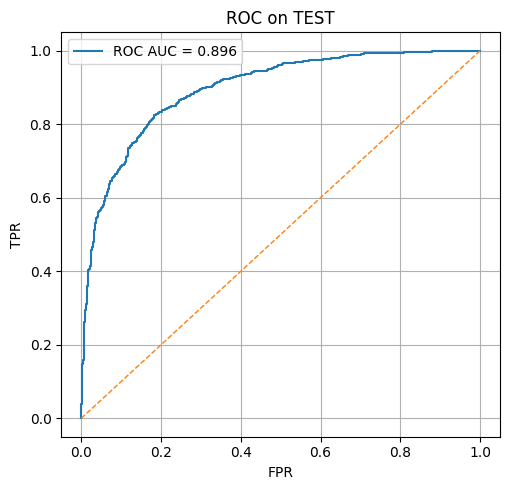

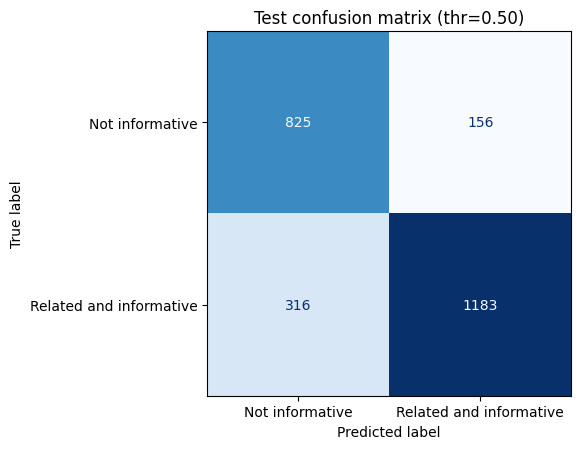

In [13]:
# === TEST ROC-AUC + ROC curve + Confusion matrix ===

# Try common variable names to locate probabilities & true labels
_candidates_prob = ["y_test_prob", "y_prob_test", "y_pred_prob", "y_pred_proba", "y_pred"]
_candidates_true = ["y_te", "y_test", "y_true_test", "y_true"]

def _first_existing(names, g):
    for n in names:
        if n in g:
            return g[n]
    raise NameError(f"Could not find any of variables: {names}")

_g = globals()
_y_prob = _first_existing(_candidates_prob, _g)
_y_true = _first_existing(_candidates_true, _g)

# Ensure 1D numpy arrays
y_test_prob = np.asarray(_y_prob).reshape(-1)
y_te        = np.asarray(_y_true).reshape(-1)

# Convert logits to probabilities if needed
if (y_test_prob.min() < 0.0) or (y_test_prob.max() > 1.0):
    y_test_prob = 1.0 / (1.0 + np.exp(-y_test_prob))

# ROC-AUC
test_roc_auc = roc_auc_score(y_te, y_test_prob)
print(f"[TEST] ROC-AUC = {test_roc_auc:.4f}")

mlflow.log_metric("test_roc_auc", float(test_roc_auc))

# ROC curve
fpr, tpr, _ = roc_curve(y_te, y_test_prob, pos_label=1)
roc_auc = auc(fpr, tpr)

fig = plt.figure(figsize=(5.2,5.0))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], "--", linewidth=1)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC on TEST"); plt.legend()
plt.grid(True); plt.tight_layout()
plt.show()

mlflow.log_figure(fig, "test_roc_curve.png")

# Confusion matrix @ threshold
threshold = 0.5
y_test_bin = (y_test_prob >= threshold).astype(int)
cm = confusion_matrix(y_te, y_test_bin)
disp = ConfusionMatrixDisplay(cm, display_labels=["Not informative", "Related and informative"])

fig_cm, ax = plt.subplots(figsize=(5.6, 4.6))
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
ax.set_title(f"Test confusion matrix (thr={threshold:.2f})")
plt.tight_layout(); plt.show()

mlflow.log_figure(fig_cm, "test_confusion_matrix.png")